<a href="https://colab.research.google.com/github/manu6521/Image_project/blob/main/Transformer_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.0 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [2]:
!pip install nltk

In [3]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 432.6 kB/s eta 0:00:00


In [4]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=06deeebbd6261465e41aeeb511d254319e10a1717bb86e46712d51f464aa83da
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [5]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:
from torchvision import transforms

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import os

import datasets
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
import multiprocessing as mp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import io, transforms
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import Seq2SeqTrainer ,Seq2SeqTrainingArguments
from transformers import VisionEncoderDecoderModel , ViTFeatureExtractor
from transformers import AutoTokenizer ,  GPT2Config , default_data_collator

# if torch.cuda.is_available():

#     device = torch.device("cuda")

#     print('There are %d GPU(s) available.' % torch.cuda.device_count())

#     print('We will use the GPU:', torch.cuda.get_device_name(0))

# else:
#     print('No GPU available, using the CPU instead.')
#     device = torch.device("cpu")

In [9]:
from transformers import VisionEncoderDecoderModel, AutoTokenizer, AutoFeatureExtractor

image_encoder_model = "google/vit-base-patch16-224-in21k"
text_decode_model = "gpt2"

# model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
#     image_encoder_model, text_decode_model)

In [10]:
# image feature extractor
feature_extractor = AutoFeatureExtractor.from_pretrained(image_encoder_model)
# text tokenizer
tokenizer = AutoTokenizer.from_pretrained(text_decode_model, add_prefix_space=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [11]:
# Define the search space
def model_init():
    # Load the model
    model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
        image_encoder_model, text_decode_model
    )


    # Set the decoder_start_token_id, eos_token_id, and pad_token_id attributes
    model.config.decoder_start_token_id = tokenizer.bos_token_id
    model.config.eos_token_id = tokenizer.eos_token_id
    model.config.pad_token_id = tokenizer.pad_token_id
    print('333333333.........333333333')
    return model





In [12]:
# GPT2 only has bos/eos tokens but not decoder_start/pad tokens
if tokenizer.pad_token is None:
  tokenizer.pad_token = tokenizer.eos_token

In [13]:
data_DIR = '/content/drive/MyDrive/flicker_trans'
ds = datasets.load_dataset("atasoglu/flickr8k-dataset", data_dir=data_DIR)

The repository for atasoglu/flickr8k-dataset contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/atasoglu/flickr8k-dataset.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

In [14]:
ds

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image_path', 'captions'],
        num_rows: 6000
    })
    test: Dataset({
        features: ['image_id', 'image_path', 'captions'],
        num_rows: 1000
    })
    validation: Dataset({
        features: ['image_id', 'image_path', 'captions'],
        num_rows: 1000
    })
})

In [15]:
# print single example
ds['train'][0]

{'image_id': '2513260012_03d33305cf',
 'image_path': '/root/.cache/huggingface/datasets/downloads/extracted/49f288ae42d8a3f5f0e61542ad189a3da11ad70e7138d770d2873fe530d173ad/Flicker8k_Dataset/2513260012_03d33305cf.jpg',
 'captions': ['A black dog is running after a white dog in the snow .',
  'Black dog chasing brown dog through snow',
  'Two dogs chase each other across the snowy ground .',
  'Two dogs play together in the snow .',
  'Two dogs running through a low lying body of water .']}

In [16]:
from PIL import Image

# text preprocessing step
def tokenization_fn(captions, max_target_length):
    """Run tokenization on captions."""
    labels = tokenizer(captions,
                      padding="max_length",
                      max_length=max_target_length,
                       is_split_into_words=True).input_ids

    return labels

# image preprocessing step
def feature_extraction_fn(image_paths, check_image=True):
    """
    Run feature extraction on images
    If `check_image` is `True`, the examples that fails during `Image.open()` will be caught and discarded.
    Otherwise, an exception will be thrown.
    """

    model_inputs = {}

    if check_image:
        images = []
        to_keep = []
        for image_file in image_paths:
            try:
                img = Image.open(image_file)
                images.append(img)
                to_keep.append(True)
            except Exception:
                to_keep.append(False)
    else:
        images = [Image.open(image_file) for image_file in image_paths]

    encoder_inputs = feature_extractor(images=images, return_tensors="np")

    return encoder_inputs.pixel_values

def preprocess_fn(examples, max_target_length, check_image = True):
    """Run tokenization + image feature extraction"""
    image_paths = examples['image_path']
    captions = examples['captions']

    model_inputs = {}
    # This contains image path column
    model_inputs['labels'] = tokenization_fn(captions, max_target_length)
    model_inputs['pixel_values'] = feature_extraction_fn(image_paths, check_image=check_image)

    return model_inputs

In [17]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    learning_rate=0.0001,
    weight_decay=0.015,
    output_dir="./image-captioning-output",
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [18]:
processed_dataset = ds.map(
    function=preprocess_fn,
    batched=True,
    fn_kwargs={"max_target_length": 128},
    remove_columns=ds['train'].column_names
)

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [19]:
!pip install ray[tune]


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 MB 35.6 MB/s eta 0:00:00


In [20]:
from transformers import default_data_collator
from ray import tune

In [21]:
import evaluate
metric = evaluate.load("rouge")

In [47]:
import numpy as np

ignore_pad_token_for_loss = True


def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]

    # rougeLSum expects newline after each sentence
    preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]

    return preds, labels


import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
import numpy as np

def compute_bleu_and_meteor(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    if ignore_pad_token_for_loss:
        # Replace -100 in the labels as we can't decode them.
        labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    # Calculate BLEU score
    bleu_scores = []
    smoothing_function = SmoothingFunction().method1  # Smoothing method for BLEU
    for pred, label in zip(decoded_preds, decoded_labels):
        reference = [label.split()]  # List of list of reference tokens
        hypothesis = pred.split()    # Hypothesis tokens
        bleu_score = sentence_bleu(reference, hypothesis, smoothing_function=smoothing_function)
        bleu_scores.append(bleu_score)

    avg_bleu_score = np.mean(bleu_scores)

    # Calculate METEOR score
    meteor_scores = []
    for pred, label in zip(decoded_preds, decoded_labels):
        meteor_scores.append(meteor_score([label], pred))

    avg_meteor_score = np.mean(meteor_scores)

    # Combine BLEU and METEOR scores
    result = {
        "bleu": round(avg_bleu_score * 100, 4),
        "meteor": round(avg_meteor_score * 100, 4)
    }

    # Add the average generation length to the result
    result["gen_len"] = np.mean([len(hypothesis) for hypothesis in preds])

    return result


In [48]:
from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    model_init=model_init,
    tokenizer=feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=processed_dataset['train'],
    eval_dataset=processed_dataset['validation'],
    data_collator=default_data_collator,
)

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.crossattention.c_attn.bias', 'h.11.crossattention.c_attn.weight', 'h.11.crossat

333333333.........333333333


In [24]:
def hyperparameter_search_function(trial):
    return {
        "learning_rate": tune.loguniform(1e-5, 5e-4),
        "per_device_train_batch_size": tune.choice([16,32, 64]),
        "per_device_eval_batch_size": tune.choice([2, 4, 8]),
        "num_train_epochs": tune.choice([2,3]),
        "weight_decay": tune.uniform(0.01, 0.1),
    }

In [25]:
# Perform hyperparameter search
best_run = trainer.hyperparameter_search(
    hp_space=hyperparameter_search_function,
    direction="maximize",
    n_trials=2,  # Number of trials
    backend="ray",  # Use Ray for distributed search
)

/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-08-21 09:42:48,027	INFO worker.py:1781 -- Started a local Ray instance.
2024-08-21 09:42:51,566	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.
2024-08-21 09:42:51,707	WARNING tune.py:902 -- AIR_VERBOSITY is set, ignoring passed-in ProgressReporter for now.


+-------------------------------------------------------------------+
| Configuration for experiment     _objective_2024-08-21_09-42-51   |
+-------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator            |
| Scheduler                        FIFOScheduler                    |
| Number of trials                 2                                |
+-------------------------------------------------------------------+

View detailed results here: /root/ray_results/_objective_2024-08-21_09-42-51
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-08-21_09-42-46_478285_1314/artifacts/2024-08-21_09-42-51/_objective_2024-08-21_09-42-51/driver_artifacts`

Trial status: 2 PENDING
Current time: 2024-08-21 09:42:51. Total running time: 0s
Logical resource usage: 0/12 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:L4)
+---------------------------------------------------------------------------

(_objective pid=6954) 2024-08-21 09:42:56.322278: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(_objective pid=6954) 2024-08-21 09:42:56.347522: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(_objective pid=6954) 2024-08-21 09:42:56.355409: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(_objective pid=6954) 2024-08-21 09:42:57.453845: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(_objective pid=6954) Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattent

(_objective pid=6954) 333333333.........333333333


  1%|          | 7/750 [00:17<26:18,  2.12s/it]



Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-08-21 09:43:21. Total running time: 30s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+---------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay |
+---------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00000   RUNNING        4.32845e-05                       16                        8                    2        0.0801722 |
| _objective_bbbc1_00001   PENDING        0.000103283                       32                        8                    2        0.0152275 |
+---------------------------------------------------------------------------------------------------------

  3%|▎         | 22/750 [00:47<24:33,  2.02s/it]


Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-08-21 09:43:52. Total running time: 1min 0s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+---------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay |
+---------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00000   RUNNING        4.32845e-05                       16                        8                    2        0.0801722 |
| _objective_bbbc1_00001   PENDING        0.000103283                       32                        8                    2        0.0152275 |
+------------------------------------------------------------------------------------------------------

  5%|▍         | 37/750 [01:18<23:55,  2.01s/it]


Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-08-21 09:44:22. Total running time: 1min 30s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+---------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay |
+---------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00000   RUNNING        4.32845e-05                       16                        8                    2        0.0801722 |
| _objective_bbbc1_00001   PENDING        0.000103283                       32                        8                    2        0.0152275 |
+-----------------------------------------------------------------------------------------------------

  7%|▋         | 51/750 [01:46<23:29,  2.02s/it]


Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-08-21 09:44:52. Total running time: 2min 0s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+---------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay |
+---------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00000   RUNNING        4.32845e-05                       16                        8                    2        0.0801722 |
| _objective_bbbc1_00001   PENDING        0.000103283                       32                        8                    2        0.0152275 |
+------------------------------------------------------------------------------------------------------

  9%|▉         | 66/750 [02:17<23:02,  2.02s/it]


Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-08-21 09:45:22. Total running time: 2min 30s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+---------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay |
+---------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00000   RUNNING        4.32845e-05                       16                        8                    2        0.0801722 |
| _objective_bbbc1_00001   PENDING        0.000103283                       32                        8                    2        0.0152275 |
+-----------------------------------------------------------------------------------------------------

 11%|█         | 81/750 [02:47<22:37,  2.03s/it]


Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-08-21 09:45:52. Total running time: 3min 0s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+---------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay |
+---------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00000   RUNNING        4.32845e-05                       16                        8                    2        0.0801722 |
| _objective_bbbc1_00001   PENDING        0.000103283                       32                        8                    2        0.0152275 |
+------------------------------------------------------------------------------------------------------

 13%|█▎        | 96/750 [03:18<22:10,  2.03s/it]


Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-08-21 09:46:22. Total running time: 3min 30s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+---------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay |
+---------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00000   RUNNING        4.32845e-05                       16                        8                    2        0.0801722 |
| _objective_bbbc1_00001   PENDING        0.000103283                       32                        8                    2        0.0152275 |
+-----------------------------------------------------------------------------------------------------

 15%|█▍        | 110/750 [03:46<22:28,  2.11s/it]


Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-08-21 09:46:52. Total running time: 4min 0s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+---------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay |
+---------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00000   RUNNING        4.32845e-05                       16                        8                    2        0.0801722 |
| _objective_bbbc1_00001   PENDING        0.000103283                       32                        8                    2        0.0152275 |
+------------------------------------------------------------------------------------------------------

 17%|█▋        | 125/750 [04:17<21:03,  2.02s/it]


Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-08-21 09:47:22. Total running time: 4min 30s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+---------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay |
+---------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00000   RUNNING        4.32845e-05                       16                        8                    2        0.0801722 |
| _objective_bbbc1_00001   PENDING        0.000103283                       32                        8                    2        0.0152275 |
+-----------------------------------------------------------------------------------------------------

 19%|█▊        | 140/750 [04:47<20:33,  2.02s/it]


Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-08-21 09:47:52. Total running time: 5min 0s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+---------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay |
+---------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00000   RUNNING        4.32845e-05                       16                        8                    2        0.0801722 |
| _objective_bbbc1_00001   PENDING        0.000103283                       32                        8                    2        0.0152275 |
+------------------------------------------------------------------------------------------------------

 21%|██        | 155/750 [05:18<20:09,  2.03s/it]


Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-08-21 09:48:22. Total running time: 5min 30s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+---------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay |
+---------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00000   RUNNING        4.32845e-05                       16                        8                    2        0.0801722 |
| _objective_bbbc1_00001   PENDING        0.000103283                       32                        8                    2        0.0152275 |
+-----------------------------------------------------------------------------------------------------

 23%|██▎       | 169/750 [05:47<19:41,  2.03s/it]


Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-08-21 09:48:52. Total running time: 6min 0s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+---------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay |
+---------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00000   RUNNING        4.32845e-05                       16                        8                    2        0.0801722 |
| _objective_bbbc1_00001   PENDING        0.000103283                       32                        8                    2        0.0152275 |
+------------------------------------------------------------------------------------------------------

 25%|██▍       | 184/750 [06:17<19:08,  2.03s/it]


Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-08-21 09:49:22. Total running time: 6min 31s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+---------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay |
+---------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00000   RUNNING        4.32845e-05                       16                        8                    2        0.0801722 |
| _objective_bbbc1_00001   PENDING        0.000103283                       32                        8                    2        0.0152275 |
+-----------------------------------------------------------------------------------------------------

 27%|██▋       | 199/750 [06:48<19:14,  2.10s/it]


Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-08-21 09:49:52. Total running time: 7min 1s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+---------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay |
+---------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00000   RUNNING        4.32845e-05                       16                        8                    2        0.0801722 |
| _objective_bbbc1_00001   PENDING        0.000103283                       32                        8                    2        0.0152275 |
+------------------------------------------------------------------------------------------------------

 29%|██▊       | 214/750 [07:19<18:08,  2.03s/it]


Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-08-21 09:50:22. Total running time: 7min 31s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+---------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay |
+---------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00000   RUNNING        4.32845e-05                       16                        8                    2        0.0801722 |
| _objective_bbbc1_00001   PENDING        0.000103283                       32                        8                    2        0.0152275 |
+-----------------------------------------------------------------------------------------------------

 30%|███       | 228/750 [07:47<17:37,  2.03s/it]


Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-08-21 09:50:52. Total running time: 8min 1s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+---------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay |
+---------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00000   RUNNING        4.32845e-05                       16                        8                    2        0.0801722 |
| _objective_bbbc1_00001   PENDING        0.000103283                       32                        8                    2        0.0152275 |
+------------------------------------------------------------------------------------------------------

 32%|███▏      | 243/750 [08:18<17:08,  2.03s/it]


Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-08-21 09:51:23. Total running time: 8min 31s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+---------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay |
+---------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00000   RUNNING        4.32845e-05                       16                        8                    2        0.0801722 |
| _objective_bbbc1_00001   PENDING        0.000103283                       32                        8                    2        0.0152275 |
+-----------------------------------------------------------------------------------------------------

 34%|███▍      | 258/750 [08:48<16:42,  2.04s/it]


Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-08-21 09:51:53. Total running time: 9min 1s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+---------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay |
+---------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00000   RUNNING        4.32845e-05                       16                        8                    2        0.0801722 |
| _objective_bbbc1_00001   PENDING        0.000103283                       32                        8                    2        0.0152275 |
+------------------------------------------------------------------------------------------------------

 36%|███▋      | 273/750 [09:19<16:02,  2.02s/it]


Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-08-21 09:52:23. Total running time: 9min 31s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+---------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay |
+---------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00000   RUNNING        4.32845e-05                       16                        8                    2        0.0801722 |
| _objective_bbbc1_00001   PENDING        0.000103283                       32                        8                    2        0.0152275 |
+-----------------------------------------------------------------------------------------------------

 38%|███▊      | 287/750 [09:47<15:49,  2.05s/it]


Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-08-21 09:52:53. Total running time: 10min 1s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+---------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay |
+---------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00000   RUNNING        4.32845e-05                       16                        8                    2        0.0801722 |
| _objective_bbbc1_00001   PENDING        0.000103283                       32                        8                    2        0.0152275 |
+-----------------------------------------------------------------------------------------------------

 40%|████      | 302/750 [10:18<15:12,  2.04s/it]


Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-08-21 09:53:23. Total running time: 10min 31s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+---------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay |
+---------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00000   RUNNING        4.32845e-05                       16                        8                    2        0.0801722 |
| _objective_bbbc1_00001   PENDING        0.000103283                       32                        8                    2        0.0152275 |
+----------------------------------------------------------------------------------------------------

 42%|████▏     | 317/750 [10:49<14:46,  2.05s/it]


Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-08-21 09:53:53. Total running time: 11min 1s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+---------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay |
+---------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00000   RUNNING        4.32845e-05                       16                        8                    2        0.0801722 |
| _objective_bbbc1_00001   PENDING        0.000103283                       32                        8                    2        0.0152275 |
+-----------------------------------------------------------------------------------------------------

 44%|████▍     | 332/750 [11:19<14:13,  2.04s/it]


Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-08-21 09:54:23. Total running time: 11min 31s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+---------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay |
+---------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00000   RUNNING        4.32845e-05                       16                        8                    2        0.0801722 |
| _objective_bbbc1_00001   PENDING        0.000103283                       32                        8                    2        0.0152275 |
+----------------------------------------------------------------------------------------------------

 46%|████▌     | 346/750 [11:48<13:39,  2.03s/it]


Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-08-21 09:54:53. Total running time: 12min 1s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+---------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay |
+---------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00000   RUNNING        4.32845e-05                       16                        8                    2        0.0801722 |
| _objective_bbbc1_00001   PENDING        0.000103283                       32                        8                    2        0.0152275 |
+-----------------------------------------------------------------------------------------------------

 48%|████▊     | 361/750 [12:18<13:11,  2.03s/it]


Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-08-21 09:55:23. Total running time: 12min 31s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+---------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay |
+---------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00000   RUNNING        4.32845e-05                       16                        8                    2        0.0801722 |
| _objective_bbbc1_00001   PENDING        0.000103283                       32                        8                    2        0.0152275 |
+----------------------------------------------------------------------------------------------------

 50%|█████     | 375/750 [12:46<10:00,  1.60s/it]
(_objective pid=6954) The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
(_objective pid=6954) Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
(_objective pid=6954) The attention mask is not set and cannot be inferred from input because pad token is same as eos token.As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
(_objective pid=6954) /usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1249: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
(_objective pid=6954)   warnings.warn(
(_objective pid=6954) 
  0%|          | 0/125 [00:00<?, ?it/s]
(_objective pid=

Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-08-21 09:55:53. Total running time: 13min 1s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+---------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay |
+---------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00000   RUNNING        4.32845e-05                       16                        8                    2        0.0801722 |
| _objective_bbbc1_00001   PENDING        0.000103283                       32                        8                    2        0.0152275 |
+-----------------------------------------------------------------------------------------------------

(_objective pid=6954) 
  2%|▏         | 3/125 [00:02<01:33,  1.30it/s]
(_objective pid=6954) The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
(_objective pid=6954) Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
(_objective pid=6954) 
  3%|▎         | 4/125 [00:03<01:47,  1.13it/s]
(_objective pid=6954) The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
(_objective pid=6954) Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
(_objective pid=6954) 
  4%|▍         | 5/125 [00:04<01:54,  1.05it/s]
(_objective pid=6954) The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable resul

Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-08-21 09:56:23. Total running time: 13min 32s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+---------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay |
+---------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00000   RUNNING        4.32845e-05                       16                        8                    2        0.0801722 |
| _objective_bbbc1_00001   PENDING        0.000103283                       32                        8                    2        0.0152275 |
+----------------------------------------------------------------------------------------------------

(_objective pid=6954) 
 25%|██▍       | 31/125 [00:32<01:41,  1.08s/it]
(_objective pid=6954) The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
(_objective pid=6954) Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
(_objective pid=6954) 
 26%|██▌       | 32/125 [00:33<01:40,  1.08s/it]
(_objective pid=6954) The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
(_objective pid=6954) Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
(_objective pid=6954) 
 26%|██▋       | 33/125 [00:34<01:39,  1.09s/it]
(_objective pid=6954) The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable re

Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-08-21 09:56:53. Total running time: 14min 2s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+---------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay |
+---------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00000   RUNNING        4.32845e-05                       16                        8                    2        0.0801722 |
| _objective_bbbc1_00001   PENDING        0.000103283                       32                        8                    2        0.0152275 |
+-----------------------------------------------------------------------------------------------------

(_objective pid=6954) The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
(_objective pid=6954) Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
(_objective pid=6954) 
 47%|████▋     | 59/125 [01:02<01:11,  1.08s/it]
(_objective pid=6954) The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
(_objective pid=6954) Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
(_objective pid=6954) 
 48%|████▊     | 60/125 [01:03<01:10,  1.09s/it]
(_objective pid=6954) The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
(_objective pid=6954) Setting `pad_token_id` to `eos_token_id`:50

Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-08-21 09:57:23. Total running time: 14min 32s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+---------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay |
+---------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00000   RUNNING        4.32845e-05                       16                        8                    2        0.0801722 |
| _objective_bbbc1_00001   PENDING        0.000103283                       32                        8                    2        0.0152275 |
+----------------------------------------------------------------------------------------------------

(_objective pid=6954) 
 69%|██████▉   | 86/125 [01:32<00:42,  1.10s/it]
(_objective pid=6954) The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
(_objective pid=6954) Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
(_objective pid=6954) 
 70%|██████▉   | 87/125 [01:33<00:41,  1.08s/it]
(_objective pid=6954) The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
(_objective pid=6954) Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
(_objective pid=6954) 
 70%|███████   | 88/125 [01:34<00:39,  1.08s/it]
(_objective pid=6954) The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable re

Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-08-21 09:57:53. Total running time: 15min 2s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+---------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay |
+---------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00000   RUNNING        4.32845e-05                       16                        8                    2        0.0801722 |
| _objective_bbbc1_00001   PENDING        0.000103283                       32                        8                    2        0.0152275 |
+-----------------------------------------------------------------------------------------------------

(_objective pid=6954) 
 91%|█████████ | 114/125 [02:02<00:11,  1.07s/it]
(_objective pid=6954) The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
(_objective pid=6954) Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
(_objective pid=6954) 
 92%|█████████▏| 115/125 [02:03<00:10,  1.07s/it]
(_objective pid=6954) The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
(_objective pid=6954) Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
(_objective pid=6954) 
 93%|█████████▎| 116/125 [02:04<00:09,  1.07s/it]
(_objective pid=6954) The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable


Trial _objective_bbbc1_00000 finished iteration 1 at 2024-08-21 09:58:08. Total running time: 15min 16s
+-------------------------------------------------+
| Trial _objective_bbbc1_00000 result             |
+-------------------------------------------------+
| checkpoint_dir_name                             |
| time_this_iter_s                        913.216 |
| time_total_s                            913.216 |
| training_iteration                            1 |
| epoch                                         1 |
| eval_gen_len                                 19 |
| eval_loss                               1.13471 |
| eval_rouge1                             26.5461 |
| eval_rouge2                              8.3554 |
| eval_rougeL                             23.0639 |
| eval_rougeLsum                          25.3755 |
| eval_runtime                            138.746 |
| eval_samples_per_second                   7.207 |
| eval_steps_per_second                     0.901 |
| objective

                                                 
100%|██████████| 125/125 [02:16<00:00,  1.15it/s]
                                                 
 51%|█████     | 382/750 [15:20<42:26,  6.92s/it]



Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-08-21 09:58:23. Total running time: 15min 32s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00000   RUNNING        4.32845e-05                       16                        8               

 53%|█████▎    | 396/750 [15:48<12:10,  2.06s/it]


Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-08-21 09:58:54. Total running time: 16min 2s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00000   RUNNING        4.32845e-05                       16                        8                 

 55%|█████▍    | 411/750 [16:19<11:30,  2.04s/it]


Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-08-21 09:59:24. Total running time: 16min 32s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00000   RUNNING        4.32845e-05                       16                        8                

 57%|█████▋    | 426/750 [16:50<10:57,  2.03s/it]


Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-08-21 09:59:54. Total running time: 17min 2s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00000   RUNNING        4.32845e-05                       16                        8                 

 59%|█████▊    | 440/750 [17:18<10:33,  2.04s/it]


Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-08-21 10:00:24. Total running time: 17min 32s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00000   RUNNING        4.32845e-05                       16                        8                

 61%|██████    | 455/750 [17:49<09:58,  2.03s/it]


Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-08-21 10:00:54. Total running time: 18min 2s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00000   RUNNING        4.32845e-05                       16                        8                 

 63%|██████▎   | 470/750 [18:19<09:27,  2.03s/it]


Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-08-21 10:01:24. Total running time: 18min 32s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00000   RUNNING        4.32845e-05                       16                        8                

 65%|██████▍   | 485/750 [18:50<08:56,  2.02s/it]


Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-08-21 10:01:54. Total running time: 19min 2s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00000   RUNNING        4.32845e-05                       16                        8                 

 67%|██████▋   | 499/750 [19:18<08:25,  2.01s/it]


(_objective pid=6954) {'loss': 1.2222, 'grad_norm': 2.7713654041290283, 'learning_rate': 1.4428167404312914e-05, 'epoch': 1.33}


 67%|██████▋   | 500/750 [19:20<08:24,  2.02s/it]


Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-08-21 10:02:24. Total running time: 19min 32s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00000   RUNNING        4.32845e-05                       16                        8                

 68%|██████▊   | 511/750 [19:50<08:22,  2.10s/it]


Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-08-21 10:02:54. Total running time: 20min 2s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00000   RUNNING        4.32845e-05                       16                        8                 

 70%|███████   | 526/750 [20:20<07:33,  2.02s/it]


Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-08-21 10:03:24. Total running time: 20min 33s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00000   RUNNING        4.32845e-05                       16                        8                

 72%|███████▏  | 540/750 [20:49<07:08,  2.04s/it]


Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-08-21 10:03:54. Total running time: 21min 3s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00000   RUNNING        4.32845e-05                       16                        8                 

 74%|███████▍  | 555/750 [21:19<06:45,  2.08s/it]


Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-08-21 10:04:24. Total running time: 21min 33s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00000   RUNNING        4.32845e-05                       16                        8                

 76%|███████▌  | 570/750 [21:50<06:06,  2.04s/it]


Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-08-21 10:04:54. Total running time: 22min 3s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00000   RUNNING        4.32845e-05                       16                        8                 

 78%|███████▊  | 585/750 [22:20<05:32,  2.01s/it]


Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-08-21 10:05:25. Total running time: 22min 33s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00000   RUNNING        4.32845e-05                       16                        8                

 80%|████████  | 600/750 [22:50<05:07,  2.05s/it]


Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-08-21 10:05:55. Total running time: 23min 3s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00000   RUNNING        4.32845e-05                       16                        8                 

 82%|████████▏ | 615/750 [23:21<04:45,  2.11s/it]


Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-08-21 10:06:25. Total running time: 23min 33s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00000   RUNNING        4.32845e-05                       16                        8                

 84%|████████▍ | 629/750 [23:49<04:04,  2.02s/it]


Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-08-21 10:06:55. Total running time: 24min 3s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00000   RUNNING        4.32845e-05                       16                        8                 

 86%|████████▌ | 644/750 [24:20<03:40,  2.08s/it]


Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-08-21 10:07:25. Total running time: 24min 33s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00000   RUNNING        4.32845e-05                       16                        8                

 88%|████████▊ | 659/750 [24:50<03:03,  2.02s/it]


Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-08-21 10:07:55. Total running time: 25min 3s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00000   RUNNING        4.32845e-05                       16                        8                 

 90%|████████▉ | 674/750 [25:21<02:34,  2.04s/it]


Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-08-21 10:08:25. Total running time: 25min 33s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00000   RUNNING        4.32845e-05                       16                        8                

 92%|█████████▏| 689/750 [25:51<02:02,  2.02s/it]


Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-08-21 10:08:55. Total running time: 26min 3s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00000   RUNNING        4.32845e-05                       16                        8                 

 94%|█████████▎| 703/750 [26:20<01:36,  2.05s/it]


Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-08-21 10:09:25. Total running time: 26min 33s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00000   RUNNING        4.32845e-05                       16                        8                

 96%|█████████▌| 718/750 [26:50<01:04,  2.00s/it]


Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-08-21 10:09:55. Total running time: 27min 3s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00000   RUNNING        4.32845e-05                       16                        8                 

 98%|█████████▊| 733/750 [27:21<00:34,  2.05s/it]


Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-08-21 10:10:25. Total running time: 27min 33s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00000   RUNNING        4.32845e-05                       16                        8                

100%|█████████▉| 748/750 [27:51<00:04,  2.01s/it]


Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-08-21 10:10:55. Total running time: 28min 4s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00000   RUNNING        4.32845e-05                       16                        8                 

100%|██████████| 750/750 [27:54<00:00,  1.59s/it]
(_objective pid=6954) The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
(_objective pid=6954) Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
(_objective pid=6954) /usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1249: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
(_objective pid=6954)   warnings.warn(
(_objective pid=6954) 
  0%|          | 0/125 [00:00<?, ?it/s]
(_objective pid=6954) The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
(_objective pid=6954) Setting `pad_token_id` to `eos_token_id`:50

Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-08-21 10:11:25. Total running time: 28min 34s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00000   RUNNING        4.32845e-05                       16                        8                

(_objective pid=6954) The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
(_objective pid=6954) Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
(_objective pid=6954) 
 14%|█▍        | 18/125 [00:18<02:03,  1.16s/it]
(_objective pid=6954) The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
(_objective pid=6954) Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
(_objective pid=6954) 
 15%|█▌        | 19/125 [00:19<02:00,  1.14s/it]
(_objective pid=6954) The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
(_objective pid=6954) Setting `pad_token_id` to `eos_token_id`:50

Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-08-21 10:11:55. Total running time: 29min 4s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00000   RUNNING        4.32845e-05                       16                        8                 

(_objective pid=6954) The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
(_objective pid=6954) Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
(_objective pid=6954) 
 36%|███▌      | 45/125 [00:48<01:26,  1.09s/it]
(_objective pid=6954) The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
(_objective pid=6954) Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
(_objective pid=6954) 
 37%|███▋      | 46/125 [00:49<01:25,  1.09s/it]
(_objective pid=6954) The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
(_objective pid=6954) Setting `pad_token_id` to `eos_token_id`:50

Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-08-21 10:12:25. Total running time: 29min 34s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00000   RUNNING        4.32845e-05                       16                        8                

(_objective pid=6954) The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
(_objective pid=6954) Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
(_objective pid=6954) 
 58%|█████▊    | 73/125 [01:18<00:56,  1.09s/it]
(_objective pid=6954) The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
(_objective pid=6954) Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
(_objective pid=6954) 
 59%|█████▉    | 74/125 [01:19<00:55,  1.09s/it]
(_objective pid=6954) The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
(_objective pid=6954) Setting `pad_token_id` to `eos_token_id`:50

Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-08-21 10:12:56. Total running time: 30min 4s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00000   RUNNING        4.32845e-05                       16                        8                 

(_objective pid=6954) 
 80%|████████  | 100/125 [01:47<00:27,  1.08s/it]
(_objective pid=6954) The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
(_objective pid=6954) Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
(_objective pid=6954) 
 81%|████████  | 101/125 [01:48<00:26,  1.09s/it]
(_objective pid=6954) The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
(_objective pid=6954) Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
(_objective pid=6954) 
 82%|████████▏ | 102/125 [01:50<00:24,  1.08s/it]
(_objective pid=6954) The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable


Trial _objective_bbbc1_00000 finished iteration 2 at 2024-08-21 10:13:25. Total running time: 30min 34s
+-------------------------------------------------+
| Trial _objective_bbbc1_00000 result             |
+-------------------------------------------------+
| checkpoint_dir_name                             |
| time_this_iter_s                        917.397 |
| time_total_s                            1830.61 |
| training_iteration                            2 |
| epoch                                         2 |
| eval_gen_len                                 19 |
| eval_loss                               1.10905 |
| eval_rouge1                             28.5341 |
| eval_rouge2                             10.1093 |
| eval_rougeL                              24.476 |
| eval_rougeLsum                          27.4081 |
| eval_runtime                            139.403 |
| eval_samples_per_second                   7.173 |
| eval_steps_per_second                     0.897 |
| objective

                                                 
100%|██████████| 750/750 [30:22<00:00,  2.43s/it]



Trial status: 1 TERMINATED | 1 PENDING
Current time: 2024-08-21 10:13:26. Total running time: 30min 34s
Logical resource usage: 0/12 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:L4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00000   TERMINATED       4.32845e-05                       16                        8        

(_objective pid=14738) 2024-08-21 10:13:31.056306: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(_objective pid=14738) 2024-08-21 10:13:31.081209: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(_objective pid=14738) 2024-08-21 10:13:31.088761: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(_objective pid=14738) 2024-08-21 10:13:32.163405: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(_objective pid=14738) Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossa

(_objective pid=14738) 333333333.........333333333


  1%|          | 3/376 [00:15<30:23,  4.89s/it]



Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2024-08-21 10:13:56. Total running time: 31min 4s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00001   RUNNING          0.000103283                       32                        8     

  3%|▎         | 10/376 [00:44<25:32,  4.19s/it]


Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2024-08-21 10:14:26. Total running time: 31min 34s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00001   RUNNING          0.000103283                       32                        8     

  5%|▍         | 18/376 [01:17<24:17,  4.07s/it]


Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2024-08-21 10:14:56. Total running time: 32min 4s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00001   RUNNING          0.000103283                       32                        8      

  7%|▋         | 25/376 [01:46<23:54,  4.09s/it]


Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2024-08-21 10:15:26. Total running time: 32min 34s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00001   RUNNING          0.000103283                       32                        8     

  9%|▊         | 32/376 [02:14<23:36,  4.12s/it]


Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2024-08-21 10:15:56. Total running time: 33min 4s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00001   RUNNING          0.000103283                       32                        8      

 11%|█         | 40/376 [02:47<22:53,  4.09s/it]


Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2024-08-21 10:16:26. Total running time: 33min 34s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00001   RUNNING          0.000103283                       32                        8     

 12%|█▎        | 47/376 [03:16<22:20,  4.07s/it]


Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2024-08-21 10:16:56. Total running time: 34min 4s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00001   RUNNING          0.000103283                       32                        8      

 14%|█▍        | 54/376 [03:44<22:13,  4.14s/it]


Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2024-08-21 10:17:26. Total running time: 34min 34s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00001   RUNNING          0.000103283                       32                        8     

 16%|█▋        | 62/376 [04:17<21:22,  4.08s/it]


Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2024-08-21 10:17:56. Total running time: 35min 4s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00001   RUNNING          0.000103283                       32                        8      

 18%|█▊        | 69/376 [04:46<20:50,  4.07s/it]


Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2024-08-21 10:18:26. Total running time: 35min 34s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00001   RUNNING          0.000103283                       32                        8     

 20%|██        | 76/376 [05:14<20:34,  4.11s/it]


Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2024-08-21 10:18:56. Total running time: 36min 4s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00001   RUNNING          0.000103283                       32                        8      

 22%|██▏       | 84/376 [05:47<19:46,  4.06s/it]


Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2024-08-21 10:19:26. Total running time: 36min 34s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00001   RUNNING          0.000103283                       32                        8     

 24%|██▍       | 91/376 [06:16<19:28,  4.10s/it]


Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2024-08-21 10:19:56. Total running time: 37min 4s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00001   RUNNING          0.000103283                       32                        8      

 26%|██▌       | 98/376 [06:45<19:09,  4.13s/it]


Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2024-08-21 10:20:26. Total running time: 37min 34s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00001   RUNNING          0.000103283                       32                        8     

 28%|██▊       | 106/376 [07:17<18:16,  4.06s/it]


Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2024-08-21 10:20:56. Total running time: 38min 5s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00001   RUNNING          0.000103283                       32                        8      

 30%|███       | 113/376 [07:46<17:50,  4.07s/it]


Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2024-08-21 10:21:26. Total running time: 38min 35s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00001   RUNNING          0.000103283                       32                        8     

 32%|███▏      | 120/376 [08:14<17:39,  4.14s/it]


Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2024-08-21 10:21:56. Total running time: 39min 5s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00001   RUNNING          0.000103283                       32                        8      

 34%|███▍      | 128/376 [08:47<16:46,  4.06s/it]


Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2024-08-21 10:22:26. Total running time: 39min 35s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00001   RUNNING          0.000103283                       32                        8     

 36%|███▌      | 135/376 [09:16<16:21,  4.07s/it]


Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2024-08-21 10:22:56. Total running time: 40min 5s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00001   RUNNING          0.000103283                       32                        8      

 38%|███▊      | 143/376 [09:48<15:57,  4.11s/it]


Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2024-08-21 10:23:26. Total running time: 40min 35s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00001   RUNNING          0.000103283                       32                        8     

 40%|███▉      | 150/376 [10:17<15:19,  4.07s/it]


Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2024-08-21 10:23:56. Total running time: 41min 5s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00001   RUNNING          0.000103283                       32                        8      

 42%|████▏     | 157/376 [10:46<15:02,  4.12s/it]


Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2024-08-21 10:24:27. Total running time: 41min 35s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00001   RUNNING          0.000103283                       32                        8     

 44%|████▍     | 165/376 [11:18<14:27,  4.11s/it]


Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2024-08-21 10:24:57. Total running time: 42min 5s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00001   RUNNING          0.000103283                       32                        8      

 46%|████▌     | 172/376 [11:47<13:59,  4.12s/it]


Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2024-08-21 10:25:27. Total running time: 42min 35s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00001   RUNNING          0.000103283                       32                        8     

 48%|████▊     | 179/376 [12:16<13:27,  4.10s/it]


Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2024-08-21 10:25:57. Total running time: 43min 5s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00001   RUNNING          0.000103283                       32                        8      

 50%|█████     | 188/376 [12:48<08:39,  2.76s/it]


Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2024-08-21 10:26:27. Total running time: 43min 35s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00001   RUNNING          0.000103283                       32                        8     

(_objective pid=14738) The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
(_objective pid=14738) Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
(_objective pid=14738) The attention mask is not set and cannot be inferred from input because pad token is same as eos token.As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
(_objective pid=14738) /usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1249: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
(_objective pid=14738)   warnings.warn(
(_objective pid=14738) 
  0%|          | 0/125 [00:00<?, ?it/s]
(_objective pid=14738) The attention mask and the pad token 

Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2024-08-21 10:26:57. Total running time: 44min 5s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00001   RUNNING          0.000103283                       32                        8      

(_objective pid=14738) The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
(_objective pid=14738) Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
(_objective pid=14738) 
 22%|██▏       | 28/125 [00:29<01:48,  1.12s/it]
(_objective pid=14738) The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
(_objective pid=14738) Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
(_objective pid=14738) 
 23%|██▎       | 29/125 [00:31<01:47,  1.12s/it]
(_objective pid=14738) The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
(_objective pid=14738) Setting `pad_token_id` to `eos_toke

Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2024-08-21 10:27:27. Total running time: 44min 35s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00001   RUNNING          0.000103283                       32                        8     

(_objective pid=14738) The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
(_objective pid=14738) Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
(_objective pid=14738) 
 44%|████▍     | 55/125 [00:59<01:17,  1.11s/it]
(_objective pid=14738) The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
(_objective pid=14738) Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
(_objective pid=14738) 
 45%|████▍     | 56/125 [01:00<01:16,  1.10s/it]
(_objective pid=14738) The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
(_objective pid=14738) Setting `pad_token_id` to `eos_toke

Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2024-08-21 10:27:57. Total running time: 45min 5s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00001   RUNNING          0.000103283                       32                        8      

(_objective pid=14738) The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
(_objective pid=14738) Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
(_objective pid=14738) 
 66%|██████▌   | 82/125 [01:29<00:47,  1.10s/it]
(_objective pid=14738) The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
(_objective pid=14738) Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
(_objective pid=14738) 
 66%|██████▋   | 83/125 [01:30<00:46,  1.10s/it]
(_objective pid=14738) The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
(_objective pid=14738) Setting `pad_token_id` to `eos_toke

Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2024-08-21 10:28:27. Total running time: 45min 35s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00001   RUNNING          0.000103283                       32                        8     

(_objective pid=14738) The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
(_objective pid=14738) Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
(_objective pid=14738) 
 87%|████████▋ | 109/125 [01:59<00:17,  1.11s/it]
(_objective pid=14738) The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
(_objective pid=14738) Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
(_objective pid=14738) 
 88%|████████▊ | 110/125 [02:00<00:16,  1.11s/it]
(_objective pid=14738) The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
(_objective pid=14738) Setting `pad_token_id` to `eos_to


Trial _objective_bbbc1_00001 finished iteration 1 at 2024-08-21 10:28:48. Total running time: 45min 56s
+-------------------------------------------------+
| Trial _objective_bbbc1_00001 result             |
+-------------------------------------------------+
| checkpoint_dir_name                             |
| time_this_iter_s                        917.993 |
| time_total_s                            917.993 |
| training_iteration                            1 |
| epoch                                         1 |
| eval_gen_len                                 19 |
| eval_loss                               1.11455 |
| eval_rouge1                             27.1148 |
| eval_rouge2                              8.7636 |
| eval_rougeL                             23.4248 |
| eval_rougeLsum                          25.8625 |
| eval_runtime                            141.669 |
| eval_samples_per_second                   7.059 |
| eval_steps_per_second                     0.882 |
| objective

                                                 
100%|██████████| 125/125 [02:19<00:00,  1.12it/s]
                                                 
 50%|█████     | 189/376 [15:16<2:24:56, 46.50s/it]



Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2024-08-21 10:28:57. Total running time: 46min 5s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00001   RUNNING          0.000103283                       32                        8     

 52%|█████▏    | 196/376 [15:45<22:59,  7.67s/it]


Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2024-08-21 10:29:27. Total running time: 46min 35s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00001   RUNNING          0.000103283                       32                        8     

 54%|█████▍    | 204/376 [16:18<12:13,  4.27s/it]


Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2024-08-21 10:29:57. Total running time: 47min 5s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00001   RUNNING          0.000103283                       32                        8      

 56%|█████▌    | 211/376 [16:47<11:16,  4.10s/it]


Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2024-08-21 10:30:27. Total running time: 47min 35s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00001   RUNNING          0.000103283                       32                        8     

 58%|█████▊    | 218/376 [17:16<10:57,  4.16s/it]


Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2024-08-21 10:30:57. Total running time: 48min 6s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00001   RUNNING          0.000103283                       32                        8      

 60%|██████    | 226/376 [17:48<10:12,  4.08s/it]


Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2024-08-21 10:31:27. Total running time: 48min 36s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00001   RUNNING          0.000103283                       32                        8     

 62%|██████▏   | 233/376 [18:17<09:46,  4.10s/it]


Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2024-08-21 10:31:57. Total running time: 49min 6s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00001   RUNNING          0.000103283                       32                        8      

 64%|██████▍   | 240/376 [18:46<09:26,  4.17s/it]


Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2024-08-21 10:32:27. Total running time: 49min 36s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00001   RUNNING          0.000103283                       32                        8     

 66%|██████▌   | 248/376 [19:19<08:42,  4.08s/it]


Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2024-08-21 10:32:57. Total running time: 50min 6s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00001   RUNNING          0.000103283                       32                        8      

 68%|██████▊   | 255/376 [19:48<08:15,  4.09s/it]


Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2024-08-21 10:33:28. Total running time: 50min 36s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00001   RUNNING          0.000103283                       32                        8     

 70%|██████▉   | 262/376 [20:16<07:52,  4.14s/it]


Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2024-08-21 10:33:58. Total running time: 51min 6s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00001   RUNNING          0.000103283                       32                        8      

 72%|███████▏  | 270/376 [20:49<07:12,  4.08s/it]


Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2024-08-21 10:34:28. Total running time: 51min 36s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00001   RUNNING          0.000103283                       32                        8     

 74%|███████▎  | 277/376 [21:18<06:43,  4.07s/it]


Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2024-08-21 10:34:58. Total running time: 52min 6s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00001   RUNNING          0.000103283                       32                        8      

 76%|███████▌  | 284/376 [21:46<06:22,  4.15s/it]


Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2024-08-21 10:35:28. Total running time: 52min 36s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00001   RUNNING          0.000103283                       32                        8     

 78%|███████▊  | 292/376 [22:19<05:40,  4.06s/it]


Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2024-08-21 10:35:58. Total running time: 53min 6s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00001   RUNNING          0.000103283                       32                        8      

 80%|███████▉  | 299/376 [22:48<05:15,  4.10s/it]


Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2024-08-21 10:36:28. Total running time: 53min 36s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00001   RUNNING          0.000103283                       32                        8     

 81%|████████▏ | 306/376 [23:17<04:51,  4.17s/it]


Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2024-08-21 10:36:58. Total running time: 54min 6s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00001   RUNNING          0.000103283                       32                        8      

 84%|████████▎ | 314/376 [23:49<04:13,  4.09s/it]


Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2024-08-21 10:37:28. Total running time: 54min 36s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00001   RUNNING          0.000103283                       32                        8     

 85%|████████▌ | 321/376 [24:18<03:46,  4.11s/it]


Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2024-08-21 10:37:58. Total running time: 55min 6s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00001   RUNNING          0.000103283                       32                        8      

 87%|████████▋ | 328/376 [24:47<03:20,  4.18s/it]


Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2024-08-21 10:38:28. Total running time: 55min 36s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00001   RUNNING          0.000103283                       32                        8     

 89%|████████▉ | 336/376 [25:20<02:43,  4.09s/it]


Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2024-08-21 10:38:58. Total running time: 56min 6s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00001   RUNNING          0.000103283                       32                        8      

 91%|█████████ | 343/376 [25:49<02:15,  4.11s/it]


Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2024-08-21 10:39:28. Total running time: 56min 36s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00001   RUNNING          0.000103283                       32                        8     

 93%|█████████▎| 350/376 [26:18<01:48,  4.16s/it]


Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2024-08-21 10:39:58. Total running time: 57min 6s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00001   RUNNING          0.000103283                       32                        8      

 95%|█████████▍| 357/376 [26:46<01:17,  4.09s/it]


Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2024-08-21 10:40:28. Total running time: 57min 36s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00001   RUNNING          0.000103283                       32                        8     

 97%|█████████▋| 365/376 [27:19<00:45,  4.09s/it]


Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2024-08-21 10:40:58. Total running time: 58min 6s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00001   RUNNING          0.000103283                       32                        8      

 99%|█████████▉| 372/376 [27:48<00:16,  4.12s/it]


Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2024-08-21 10:41:28. Total running time: 58min 36s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00001   RUNNING          0.000103283                       32                        8     

100%|██████████| 376/376 [27:59<00:00,  2.73s/it]
(_objective pid=14738) The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
(_objective pid=14738) Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
(_objective pid=14738) /usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1249: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
(_objective pid=14738)   warnings.warn(
(_objective pid=14738) 
  0%|          | 0/125 [00:00<?, ?it/s]
(_objective pid=14738) The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
(_objective pid=14738) Setting `pad_token_id` to `eos_token

Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2024-08-21 10:41:58. Total running time: 59min 7s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00001   RUNNING          0.000103283                       32                        8      

(_objective pid=14738) The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
(_objective pid=14738) Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
(_objective pid=14738) 
 10%|▉         | 12/125 [00:12<02:03,  1.09s/it]
(_objective pid=14738) The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
(_objective pid=14738) Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
(_objective pid=14738) 
 10%|█         | 13/125 [00:13<02:02,  1.09s/it]
(_objective pid=14738) The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
(_objective pid=14738) Setting `pad_token_id` to `eos_toke

Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2024-08-21 10:42:28. Total running time: 59min 37s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00001   RUNNING          0.000103283                       32                        8     

(_objective pid=14738) The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
(_objective pid=14738) Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
(_objective pid=14738) 
 31%|███       | 39/125 [00:41<01:34,  1.09s/it]
(_objective pid=14738) The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
(_objective pid=14738) Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
(_objective pid=14738) 
 32%|███▏      | 40/125 [00:42<01:33,  1.10s/it]
(_objective pid=14738) The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
(_objective pid=14738) Setting `pad_token_id` to `eos_toke

Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2024-08-21 10:42:58. Total running time: 1hr 0min 7s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00001   RUNNING          0.000103283                       32                        8   

(_objective pid=14738) 
 53%|█████▎    | 66/125 [01:11<01:04,  1.10s/it]
(_objective pid=14738) The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
(_objective pid=14738) Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
(_objective pid=14738) 
 54%|█████▎    | 67/125 [01:12<01:03,  1.10s/it]
(_objective pid=14738) The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
(_objective pid=14738) Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
(_objective pid=14738) 
 54%|█████▍    | 68/125 [01:13<01:02,  1.09s/it]
(_objective pid=14738) The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain rel

Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2024-08-21 10:43:28. Total running time: 1hr 0min 37s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00001   RUNNING          0.000103283                       32                        8  

(_objective pid=14738) 
 74%|███████▍  | 93/125 [01:41<00:35,  1.11s/it]
(_objective pid=14738) The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
(_objective pid=14738) Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
(_objective pid=14738) 
 75%|███████▌  | 94/125 [01:42<00:34,  1.11s/it]
(_objective pid=14738) The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
(_objective pid=14738) Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
(_objective pid=14738) 
 76%|███████▌  | 95/125 [01:43<00:33,  1.11s/it]
(_objective pid=14738) The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain rel

Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2024-08-21 10:43:58. Total running time: 1hr 1min 7s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     ..._train_batch_size     ...e_eval_batch_size     num_train_epochs     weight_decay     iter     total time (s)     eval_loss     eval_rouge1     eval_rouge2     eval_rougeL |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_bbbc1_00001   RUNNING          0.000103283                       32                        8   

(_objective pid=14738) 
 96%|█████████▌| 120/125 [02:11<00:05,  1.11s/it]
(_objective pid=14738) The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
(_objective pid=14738) Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
(_objective pid=14738) 
 97%|█████████▋| 121/125 [02:12<00:04,  1.11s/it]
(_objective pid=14738) The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
(_objective pid=14738) Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
(_objective pid=14738) 
 98%|█████████▊| 122/125 [02:13<00:03,  1.11s/it]
(_objective pid=14738) The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain 


Trial _objective_bbbc1_00001 finished iteration 2 at 2024-08-21 10:44:06. Total running time: 1hr 1min 15s
+-------------------------------------------------+
| Trial _objective_bbbc1_00001 result             |
+-------------------------------------------------+
| checkpoint_dir_name                             |
| time_this_iter_s                        918.834 |
| time_total_s                            1836.83 |
| training_iteration                            2 |
| epoch                                         2 |
| eval_gen_len                                 19 |
| eval_loss                               1.08496 |
| eval_rouge1                             29.7345 |
| eval_rouge2                              11.103 |
| eval_rougeL                             25.4252 |
| eval_rougeLsum                          28.5208 |
| eval_runtime                            141.195 |
| eval_samples_per_second                   7.082 |
| eval_steps_per_second                     0.885 |
| object

In [26]:
# Print the best hyperparameters
print("Best hyperparameters found:", best_run.hyperparameters)

Best hyperparameters found: {'learning_rate': 0.0001032833974654987, 'per_device_train_batch_size': 32, 'per_device_eval_batch_size': 8, 'num_train_epochs': 2, 'weight_decay': 0.015227525095137952}


In [49]:
trainer.train()


Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.crossattention.c_attn.bias', 'h.11.crossattention.c_attn.weight', 'h.11.crossat

333333333.........333333333


Epoch,Training Loss,Validation Loss,Bleu,Gen Len
1,No log,1.115497,1.266800,20.000000
2,No log,1.086956,1.624200,20.000000


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generati

TrainOutput(global_step=376, training_loss=1.1568872167709026, metrics={'train_runtime': 1822.2579, 'train_samples_per_second': 6.585, 'train_steps_per_second': 0.206, 'total_flos': 2.165566693441536e+18, 'train_loss': 1.1568872167709026, 'epoch': 2.0})

In [28]:
# Save the fine-tuned model
trainer.save_model("./fine-tuned-image-captioning-model")


In [46]:
print(result)


{'eval_loss': 1.0868618488311768, 'eval_rouge1': 29.7012, 'eval_rouge2': 11.071, 'eval_rougeL': 25.4083, 'eval_rougeLsum': 28.4728, 'eval_gen_len': 19.0, 'eval_runtime': 142.9224, 'eval_samples_per_second': 6.997, 'eval_steps_per_second': 0.875, 'epoch': 2.0}


In [34]:
import torch
import matplotlib.pyplot as plt
from PIL import Image

# Function to process image, generate caption, and display both
def display_image_with_caption(image_path):
    # Open and display the image
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Move the model to the GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    # Preprocess the image and move the tensor to the same device as the model
    pixel_values = feature_extractor(images=[img], return_tensors="pt").pixel_values.to(device)

    # Create the attention mask
    attention_mask = torch.ones(pixel_values.shape[:-1], device=device)
    # Generate predictions
    model_instance = trainer.model
    predicted_ids = model_instance.generate(pixel_values,
                                            attention_mask = attention_mask)

    # Decode the predicted IDs to a caption
    predicted_caption = tokenizer.decode(predicted_ids[0], skip_special_tokens=True)

    # Print the predicted caption
    print("Predicted Caption:", predicted_caption)
    return predicted_caption
# Path to the image


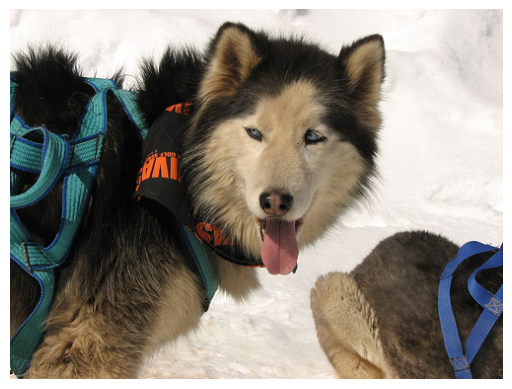

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1249: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Predicted Caption:  A dog is running through the snow. A dog runs through the snow. A dog runs through


' A dog is running through the snow. A dog runs through the snow. A dog runs through'

In [35]:
image_path = '/content/drive/MyDrive/Flicker8k_Dataset/1287064529_aa4e4f3c31.jpg'

# Display the image and predicted caption
display_image_with_caption(image_path)


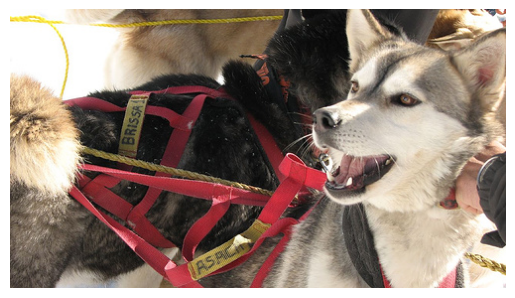

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Predicted Caption:  A dog is running through a field of grass. A dog runs through a field of grass.


' A dog is running through a field of grass. A dog runs through a field of grass.'

In [36]:
image_path = '/content/drive/MyDrive/Flicker8k_Dataset/1287920676_d21a0b289b.jpg'

# Display the image and predicted caption
display_image_with_caption(image_path)

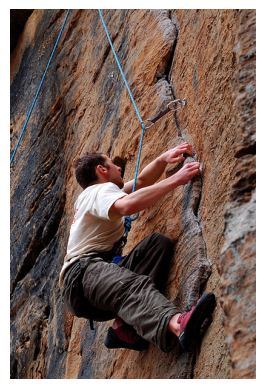

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Predicted Caption:  A man in a red shirt is climbing a rock face. A man in a red shirt is


' A man in a red shirt is climbing a rock face. A man in a red shirt is'

In [39]:
image_path = '/content/drive/MyDrive/Flicker8k_Dataset/111537217_082a4ba060.jpg'

# Display the image and predicted caption
display_image_with_caption(image_path)